#  **Project: Capstone Project 2– v1**

### **Accessing and filtering the Data**

1 . **Read data **

    Read Data from csv file 201710-citibike-tripdata.csv.

In [1]:
#Import Pandas and read csv into a DataFrame

import pandas as pd

def filter_csv_to_df(filename, filters, chunk):
    
    df_new=pd.DataFrame()

    if chunk <= 10000 or chunk >= 100000000:
        chunk = 10 ** 8
        
    for data in pd.read_csv(filename, chunksize=chunk, low_memory=False):
        df = pd.DataFrame(data)
        df_new = pd.concat([df_new, df], axis=0)
        
        if filters == 'N':
            filter_df = df_new.loc[df_new['usertype'] != 'Subscriber']
        else:
            filter_df = df_new.loc[df_new['usertype'] == 'Subscriber']
            
    return filter_df


In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import bokeh.plotting as bkp
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set()

file_list = ['../data/201710-citibike-tripdata.csv', '../data/201711-citibike-tripdata.csv', '../data/201712-citibike-tripdata.csv']

df_sub = pd.DataFrame()
df_cust = pd.DataFrame()

for file in file_list:
        data_sub = filter_csv_to_df(file, 'Y', 100000000)
        
        df_sub = pd.concat([df_sub, data_sub], axis=0)
        
        data_cust = filter_csv_to_df(file, 'N', 100000000)

        df_cust = pd.concat([df_cust, data_cust], axis=0)

        

In [3]:
print (df_sub.shape)
print (df_cust.shape)

(3789518, 15)
(328690, 15)


In [4]:
# Seperate DATES and TIME in standard format
# Convert birth year to int, calculate User age and drop User with age > 99 (outliers)

# Calculate Driver Age.
df_sub = df_sub.dropna(subset = ['birth year'])
df_cust = df_cust.dropna(subset = ['birth year'])

df_sub['birth year'] = df_sub['birth year'].astype(int)
df_cust['birth year'] = df_cust['birth year'].astype(int)

df_sub['driver_age'] = pd.to_datetime('today').year-df_sub['birth year']
df_cust['driver_age'] = pd.to_datetime('today').year-df_cust['birth year']


df_sub = df_sub.query("driver_age < 100 ")
df_cust = df_cust.query("driver_age < 100 ")

### Rename Few column for easy reference

df_sub = df_sub.rename(index=str, columns={"start station id": 'start_id', "start station name": "start_name"})
df_cust = df_cust.rename(index=str, columns={"start station id": "start_id", "start station name": "start_name"})

df_sub = df_sub.rename(index=str, columns={"end station id": "end_id", "end station name": "end_name"})
df_cust = df_cust.rename(index=str, columns={"end station id": "end_id", "end station name": "end_name"})

df_sub = df_sub.rename(index=str, columns={"start station latitude": "start_lat", "start station longitude": "start_lon"})
df_cust = df_cust.rename(index=str, columns={"start station latitude": "start_lat", "start station longitude": "start_lon"})

df_sub = df_sub.rename(index=str, columns={"end station latitude": "end_lat", "end station longitude": "end_lon"})
df_cust = df_cust.rename(index=str, columns={"end station latitude": "end_lat", "end station longitude": "end_lon"})

df_sub.insert(0, 'trip_id', range(1, 1 + len(df_sub)))
df_cust.insert(0, 'trip_id', range(1, 1 + len(df_cust)))

print (df_sub.head(10))
print (df_sub.shape)

print (df_cust.head(10))
print (df_cust.shape)

    trip_id  tripduration            starttime             stoptime  start_id  \
0         1           457  2017-10-01 00:00:00  2017-10-01 00:07:38       479   
2         2           761  2017-10-01 00:00:27  2017-10-01 00:13:09       504   
5         3           260  2017-10-01 00:00:38  2017-10-01 00:04:58      3443   
7         4           808  2017-10-01 00:00:41  2017-10-01 00:14:09      3305   
8         5          1143  2017-10-01 00:00:42  2017-10-01 00:19:46       284   
9         6           527  2017-10-01 00:00:41  2017-10-01 00:09:29       432   
10        7           516  2017-10-01 00:00:47  2017-10-01 00:09:24      3430   
12        8           439  2017-10-01 00:00:53  2017-10-01 00:08:13       470   
13        9           292  2017-10-01 00:00:55  2017-10-01 00:05:47      3414   
14       10           242  2017-10-01 00:00:54  2017-10-01 00:04:56      3328   

                    start_name  start_lat  start_lon  end_id  \
0              9 Ave & W 45 St  40.760193 -7

In [5]:
# extract date and hour from Datetime column
# create a unique trip id for each trip

df_sub['startdate'] = pd.to_datetime(df_sub['starttime']).dt.date
df_cust['startdate'] = pd.to_datetime(df_cust['starttime']).dt.date

df_sub['starthour'] = pd.to_datetime(df_sub['starttime']).dt.hour
df_cust['starthour'] = pd.to_datetime(df_cust['starttime']).dt.hour

df_sub['enddate'] = pd.to_datetime(df_sub['stoptime']).dt.date
df_cust['enddate'] = pd.to_datetime(df_cust['stoptime']).dt.date

df_sub['endhour'] = pd.to_datetime(df_sub['stoptime']).dt.hour
df_cust['endhour'] = pd.to_datetime(df_cust['stoptime']).dt.hour

df_sub['start_day'] = pd.to_datetime(df_sub['starttime']).dt.dayofweek
df_cust['start_day'] = pd.to_datetime(df_cust['starttime']).dt.dayofweek


In [6]:
# Create New columns to identify if Trip was free i.e covered in the pass or not
# what are paid units of each trip and $ paid based on plans

df_sub['free_trip'] = np.where(df_sub['tripduration'] <= 2700, 1, 0)
df_cust['free_trip'] = np.where(df_cust['tripduration'] <= 1800, 1, 0)

df_sub['paidunits'] = np.where(df_sub['free_trip'] == 0 ,np.floor((df_sub['tripduration']-2700)/900), 0)
df_cust['paidunits'] = np.where(df_cust['free_trip'] == 0 ,np.floor((df_cust['tripduration']-1800)/900), 0)

df_sub['paidamount'] = np.where(df_sub['paidunits'] > 0 ,df_sub['paidunits']*2.5, 0)
df_cust['paidamount'] = np.where(df_cust['paidunits'] > 0 ,df_cust['paidunits']*4.0, 0)

print (df_sub.tail(10))
print (df_sub.shape)

print (df_cust.tail(10))
print (df_cust.shape)

        trip_id  tripduration            starttime             stoptime  \
889957  3726257           411  2017-12-31 23:49:34  2017-12-31 23:56:25   
889958  3726258           433  2017-12-31 23:49:36  2017-12-31 23:56:50   
889959  3726259           606  2017-12-31 23:50:04  2018-01-01 00:00:11   
889960  3726260          1088  2017-12-31 23:50:08  2018-01-01 00:08:16   
889961  3726261           429  2017-12-31 23:52:25  2017-12-31 23:59:34   
889962  3726262           397  2017-12-31 23:54:22  2018-01-01 00:01:00   
889963  3726263           332  2017-12-31 23:54:44  2018-01-01 00:00:16   
889964  3726264           565  2017-12-31 23:56:07  2018-01-01 00:05:33   
889965  3726265          1659  2017-12-31 23:57:16  2018-01-01 00:24:56   
889966  3726266          1279  2017-12-31 23:58:56  2018-01-01 00:20:16   

        start_id            start_name  start_lat  start_lon  end_id  \
889957      3288       E 88 St & 1 Ave  40.778301 -73.948813    3292   
889958      3288       E 88 St

In [7]:
# Create a DF for unique list of station

df_station1 = df_sub[['start_id', 'start_name']]
df_station2 = df_sub[['end_id', 'end_name']]

df_station1['start_id'] = df_sub['start_id'].astype(int)
df_station2['end_id'] = df_sub['end_id'].astype(int)

df_station1.drop_duplicates()
df_station2.drop_duplicates()

/Users/jitendra_agarwal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/jitendra_agarwal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,end_id,end_name
0,478,11 Ave & W 41 St
2,350,Clinton St & Grand St
5,468,Broadway & W 56 St
7,305,E 58 St & 3 Ave
8,355,Bayard St & Baxter St
9,295,Pike St & E Broadway
10,3090,N 8 St & Driggs Ave
12,458,11 Ave & W 27 St
13,3346,Berkeley Pl & 7 Ave
14,3314,W 95 St & Broadway


In [8]:
#create a Df for unique list of station
df_station1.append(df_station2)

df_stations = df_station1.rename(index=str, columns={"start_id": 'station_id', "start_name": "station_name"})

df_stations.set_index(['station_id'], append=True)
df_stations = df_stations.sort_values(['station_id']).drop_duplicates(subset=['station_id'])

print(df_stations)

         station_id                         station_name
26364            72                     W 52 St & 11 Ave
968399           79             Franklin St & W Broadway
39921            82               St James Pl & Pearl St
138400           83        Atlantic Ave & Fort Greene Pl
658986          116                      W 17 St & 8 Ave
124711          119             Park Ave & St Edwards St
186185          120          Lexington Ave & Classon Ave
698677          127                Barrow St & Hudson St
211319          128             MacDougal St & Prince St
138117          143            Clinton St & Joralemon St
886677          144                  Nassau St & Navy St
457698          146                 Hudson St & Reade St
1180476         150                    E 2 St & Avenue C
336461          151             Cleveland Pl & Spring St
781940          152                Warren St & Church St
954362          153                      E 40 St & 5 Ave
220041          157            

In [9]:
# few more cleanup and Descibe the dataframe.
df_sub['starthour'] = df_sub['starthour'].astype(int)
df_sub['endhour'] = df_sub['endhour'].astype(int)
df_sub['start_day'] = df_sub['start_day'].astype(int)

# Drop columns which are not needed to make df lighter 

df_sub.drop(['starttime', 'stoptime', 'birth year', 'start_name', 'end_name'], axis=1, inplace=True)

print(df_sub.head())
df_sub.describe()

   trip_id  tripduration  start_id  start_lat  start_lon  end_id    end_lat  \
0        1           457       479  40.760193 -73.991255     478  40.760301   
2        2           761       504  40.732219 -73.981656     350  40.715595   
5        3           260      3443  40.761330 -73.979820     468  40.765265   
7        4           808      3305  40.781122 -73.949656     305  40.760958   
8        5          1143       284  40.739017 -74.002638     355  40.716021   

     end_lon  bikeid    usertype  gender  driver_age   startdate  starthour  \
0 -73.998842   30951  Subscriber       1          33  2017-10-01          0   
2 -73.987030   28713  Subscriber       1          26  2017-10-01          0   
5 -73.981923   27600  Subscriber       1          28  2017-10-01          0   
7 -73.967245   17737  Subscriber       1          25  2017-10-01          0   
8 -73.999744   20172  Subscriber       1          26  2017-10-01          0   

      enddate  endhour  start_day  free_trip  paid

,trip_id,tripduration,start_id,start_lat,start_lon,end_id,end_lat,end_lon,bikeid,gender,driver_age,starthour,endhour,start_day,free_trip,paidunits,paidamount
count,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06,3.726266e+06
mean,1.863134e+06,7.712979e+02,1.440701e+03,4.073716e+01,-7.398286e+01,1.428904e+03,4.073715e+01,-7.398373e+01,2.559676e+04,1.241310e+00,3.903543e+01,1.367407e+01,1.381377e+01,2.706733e+00,9.930877e-01,7.167577e-02,1.791894e-01
std,1.075680e+06,1.039112e+04,1.388033e+03,1.244255e-01,2.175515e-01,1.385444e+03,4.591808e-02,5.712936e-02,5.982522e+03,4.392722e-01,1.186143e+01,4.900341e+00,4.928896e+00,1.891782e+00,8.285230e-02,1.151388e+01,2.878470e+01
min,1.000000e+00,6.100000e+01,7.200000e+01,0.000000e+00,-7.403423e+01,7.200000e+01,0.000000e+00,-7.406692e+01,1.452900e+04,0.000000e+00,1.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.315672e+05,3.410000e+02,3.730000e+02,4.071912e+01,-7.399490e+01,3.680000e+02,4.071911e+01,-7.399530e+01,1.956700e+04,1.000000e+00,3.000000e+01,9.000000e+00,9.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,1.863134e+06,5.500000e+02,4.950000e+02,4.073902e+01,-7.398683e+01,4.920000e+02,4.073827e+01,-7.398700e+01,2.739700e+04,1.000000e+00,3.600000e+01,1.400000e+01,1.400000e+01,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,2.794700e+06,9.080000e+02,3.166000e+03,4.075641e+01,-7.397536e+01,3.164000e+03,4.075527e+01,-7.397575e+01,3.093300e+04,1.000000e+00,4.800000e+01,1.800000e+01,1.800000e+01,4.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,3.726266e+06,6.974419e+06,3.654000e+03,4.550585e+01,0.000000e+00,3.654000e+03,4.550636e+01,0.000000e+00,3.348100e+04,2.000000e+00,9.800000e+01,2.300000e+01,2.300000e+01,6.000000e+00,1.000000e+00,7.746000e+03,1.936500e+04


In [10]:
# Get Weather Data and  Cleanup to get daily minimum and average temperature for each day of Q4.
# Get summary data provided by Citibike on no of subscriber and daily pass purchases.

df_LMT = pd.DataFrame(pd.read_csv('../data/LMT_Q42017.csv'))
df_AVGT = pd.DataFrame(pd.read_csv('../data/AVGT_Q42017.csv'))
df_summ = pd.DataFrame(pd.read_csv('../data/2017Q4-summary.csv'))

df1 = pd.DataFrame()
df1 = pd.concat([df1, df_LMT['Oct'], df_LMT['Nov'], df_LMT['Dec']], axis=0)
df1 = df1.rename(index=str, columns={0: 'LMT'})

df2 = pd.DataFrame()
df2 = pd.concat([df2, df_AVGT['Oct'], df_AVGT['Nov'], df_AVGT['Dec']], axis=0)
df2 = df2.rename(index=str, columns={0: 'AVGT'})

df= pd.concat([df1, df2], axis=1)
df.insert(0, 'id', range(1, 1 + len(df)))
df_temp = df.query('id != 62')
df_temp['trip_date'] = pd.to_datetime(np.arange(92), unit='D', origin=pd.Timestamp('2017-10-01'))
df_temp.reset_index(inplace=True)
df_temp.set_index('trip_date')

df_temp['LMT'] = df_temp['LMT'].astype(int)
df_temp['AVGT'] = df_temp['AVGT'].astype(float)

print(df_summ.info)

<bound method DataFrame.info of         Date  Trips   Miles  Members  24-Hour-Passes  3-Day-Passes
0    10/1/17  55503  139011   246193            3511           235
1    10/2/17  65509  141748   246402            1408           242
2    10/3/17  69105  135800   246566            1258           194
3    10/4/17  71453  150324   246742            1377           188
4    10/5/17  70173  150437   246893            1365           251
5    10/6/17  70249  148395   247025            2104           383
6    10/7/17  63630  153928   247206            4996           356
7    10/8/17  41039  100790   247336            2233           192
8    10/9/17  38390   78912   247453             594            84
9   10/10/17  74117  155978   247615            2016           312
10  10/11/17  63587  126748   247767            1146           161
11  10/12/17  61244  123433   247896            1070           169
12  10/13/17  67016  136608   248038            1768           308
13  10/14/17  58771  142476   

/Users/jitendra_agarwal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jitendra_agarwal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jitendra_agarwal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

In [14]:
#Calculate Unit Economics and create Monthly summary and calculate total monthyl revenue based on pricing

trip_bymonth = df_sub.groupby(pd.to_datetime(df_sub['startdate']).dt.month).agg({'tripduration': 'sum', 'bikeid':'nunique', 'trip_id':'count', 'paidunits':'sum' })
trip_bymonth = trip_bymonth.rename(index=str, columns={"tripduration": 'total_trip_time', "bikeid": "no_of_bikes", "trip_id": "no_of_trips"})

trip_bymonth_cust = df_cust.groupby(pd.to_datetime(df_cust['startdate']).dt.month).agg({'tripduration': 'sum', 'bikeid':'nunique', 'start_id':'count', 'paidunits':'sum' })
trip_bymonth_cust = trip_bymonth_cust.rename(index=str, columns={"tripduration": 'total_trip_time', "bikeid": "no_of_bikes", "start_id": "no_of_trips"})

trip_bymonth_summ = df_summ.groupby(pd.to_datetime(df_summ['Date']).dt.month).agg({'Trips': 'sum', 'Miles':'sum', 'Members':'max', '24-Hour-Passes':'sum', '3-Day-Passes':'sum' })

print('--------------------------------------------------------------------------')

avg_mile=7.456/60/60
print('As per Citi Bike, avg distance traveled per second in miles is=',avg_mile ) 
print('Total unique bikes used by subscribers in Q4=',len(df_sub['bikeid'].unique() )) 
print('Total No of Trips by subscribers in Q4=',len(df_sub['bikeid']) )
print('Each Subscriber pays per month=', 14.95)
print('--------------------------------------------------------------------------')

#caclulate total mile traveled, average mile per bike, avg time per bike, average mile per trip, average time per trip
trip_bymonth['month'] = ['OCT', 'NOV', 'DEC']
trip_bymonth['total_distance'] = np.around(trip_bymonth['total_trip_time']*avg_mile, decimals=2)

trip_bymonth['avg_dis_per_trip'] = np.around(trip_bymonth['total_distance']/trip_bymonth['no_of_trips'], decimals=2)
trip_bymonth['avg_time_per_trip'] = np.around((trip_bymonth['total_trip_time']/trip_bymonth['no_of_trips'])/60, decimals=2)

trip_bymonth['avg_trip_per_bike'] = np.around(trip_bymonth['no_of_trips']/trip_bymonth['no_of_bikes'], decimals=2)
trip_bymonth['avg_dis_per_bike'] = np.around(trip_bymonth['total_distance']/trip_bymonth['no_of_bikes'], decimals=2)
trip_bymonth['avg_time_per_bike'] = np.around((trip_bymonth['total_trip_time']/trip_bymonth['no_of_bikes'])/60, decimals=2)

trip_bymonth_summ['pass_revenue_bysubs'] = np.around(trip_bymonth_summ['Members']*14.95, decimals=2)
trip_bymonth_summ['pass_revenue_bycust_1d'] = np.around(trip_bymonth_summ['24-Hour-Passes']*12, decimals=2)
trip_bymonth_summ['pass_revenue_bycust_3d'] = np.around(trip_bymonth_summ['3-Day-Passes']*24, decimals=2)

trip_bymonth['paid_trip_revenue_bysubs'] = np.around(trip_bymonth['paidunits']*2.5, decimals=2)
trip_bymonth_cust['paid_trip_revenue_bycust'] = np.around(trip_bymonth_cust['paidunits']*4, decimals=2)

trip_bymonth['paid_trip_monthly_revenue'] = trip_bymonth['paid_trip_revenue_bysubs']+trip_bymonth_cust['paid_trip_revenue_bycust']
trip_bymonth['paid_trip_revenue_bycust'] = trip_bymonth['paid_trip_monthly_revenue']-trip_bymonth['paid_trip_revenue_bysubs']

trip_bymonth_summ['All_pass_monthly_revenue'] = trip_bymonth_summ['pass_revenue_bysubs'] + trip_bymonth_summ['pass_revenue_bycust_1d'] + trip_bymonth_summ['pass_revenue_bycust_3d']

trip_bymonth['avg_reven_per_bike'] = np.around(5024220/trip_bymonth['no_of_bikes'], decimals=2)
trip_bymonth['avg_reven_per_trip'] = np.around(5024220/trip_bymonth['no_of_trips'], decimals=2)

print(trip_bymonth)
print('--------------------------------------------------------------------------')
print(trip_bymonth_summ)
print('--------------------------------------------------------------------------')

print("Total Q4 Revenue = " ,np.around(trip_bymonth_summ['All_pass_monthly_revenue'].sum() + trip_bymonth['paid_trip_monthly_revenue'].sum()))
print("Average monthly Revenue = " , np.around((trip_bymonth_summ['All_pass_monthly_revenue'].sum() + trip_bymonth['paid_trip_monthly_revenue'].sum())/3))


--------------------------------------------------------------------------
As per Citi Bike, avg distance traveled per second in miles is= 0.0020711111111111112
Total unique bikes used by subscribers in Q4= 13054
Total No of Trips by subscribers in Q4= 3726266
Each Subscriber pays per month= 14.95
--------------------------------------------------------------------------
           total_trip_time  no_of_bikes  no_of_trips  paidunits month  \
startdate                                                               
10              1355418246        11516      1663401   136690.0   OCT   
11               916593277        12773      1220354    77370.0   NOV   
12               602049732        11109       842511    53023.0   DEC   

           total_distance  avg_dis_per_trip  avg_time_per_trip  \
startdate                                                        
10             2807221.79              1.69              13.58   
11             1898366.52              1.56              12.52

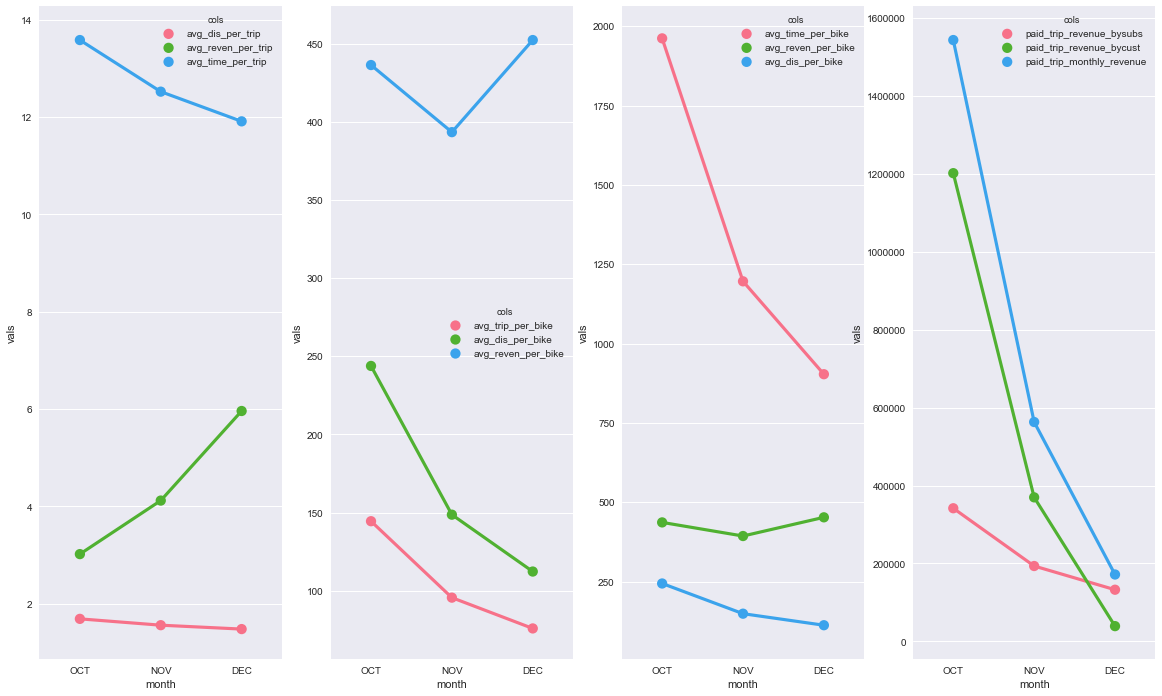

In [26]:
# Plot the Key unit metrics per trip and per bike for each month

df = trip_bymonth[['month','avg_dis_per_trip','avg_reven_per_trip','avg_time_per_trip']]
df1 = df.melt('month', var_name='cols',  value_name='vals')

df = trip_bymonth[['month','avg_trip_per_bike','avg_dis_per_bike','avg_reven_per_bike']]
df2 = df.melt('month', var_name='cols',  value_name='vals')

df = trip_bymonth[['month','avg_time_per_bike','avg_reven_per_bike','avg_dis_per_bike']]
df3 = df.melt('month', var_name='cols',  value_name='vals')

df = trip_bymonth[['month','paid_trip_revenue_bysubs','paid_trip_revenue_bycust','paid_trip_monthly_revenue']]
df4 = df.melt('month', var_name='cols',  value_name='vals')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,12))

ax1.legend(loc=1)
ax2.legend(loc=2)
ax3.legend(loc=1)
ax4.legend(loc=1)

sns.factorplot(x="month", y="vals", hue='cols', data=df1, palette="husl", ax=ax1, legend = False)
sns.factorplot(x="month", y="vals", hue='cols', data=df2, palette="husl", ax=ax2, legend = False)
sns.factorplot(x="month", y="vals", hue='cols', data=df3, palette="husl", ax=ax3, legend = False)
sns.factorplot(x="month", y="vals", hue='cols', data=df4, palette="husl", ax=ax4, legend = False)

plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)


/Users/jitendra_agarwal/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


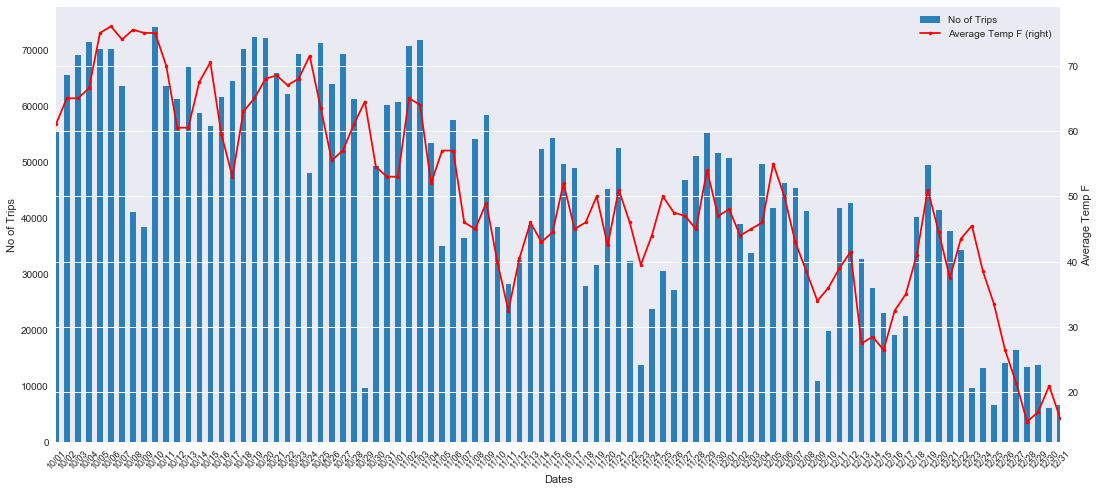

In [56]:
# How many trips happened each day of Q4 and plot it with the average temp for each day

newdf_c = df_sub.groupby(['startdate']).agg({'trip_id':{'counts': 'count'}})

ax1 = df_summ.Trips.plot(kind = 'bar', figsize=(18, 8), color='#2c7fb8', linewidth=.01, label="No of Trips", legend=True)
ax2 = df_temp.AVGT.plot(secondary_y=True, marker='.', label="Average Temp F", color='red', legend=True)

ax1.set_xticklabels(labels=pd.to_datetime(df_summ['Date']).dt.strftime('%m/%d'), fontdict={'fontsize':9}, rotation=45)
ax1.set_xlabel("Dates")
ax1.set_ylabel("No of Trips")
ax2.set_ylabel("Average Temp F")

plt.show()

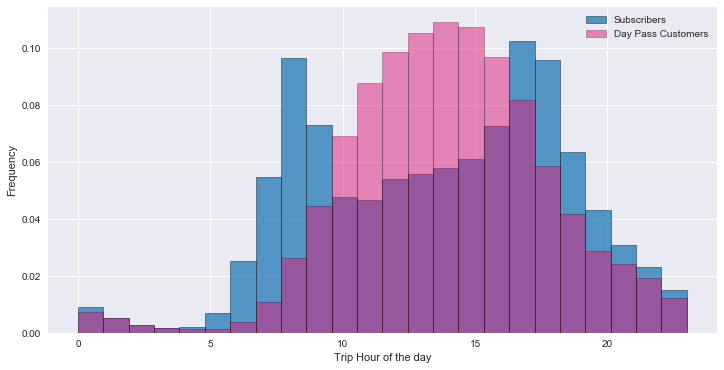

In [58]:
# Plot trip distribution by hour of the day in entire Q4 for Subsribers

plt.figure(figsize=(12,6))
df_sub['starthour'].plot('hist', legend=True, normed=True, color='#2c7fb8', alpha = 0.8, label="Subscribers", edgecolor='black', linewidth=.5, bins=24)
df_cust['starthour'].plot('hist', legend=True, normed=True, color='#dd1c77', alpha = 0.5, label="Day Pass Customers", edgecolor='black', linewidth=.5, bins=24)
_ = plt.xlabel('Trip Hour of the day')
_ = plt.ylabel('Frequency')
plt.show()




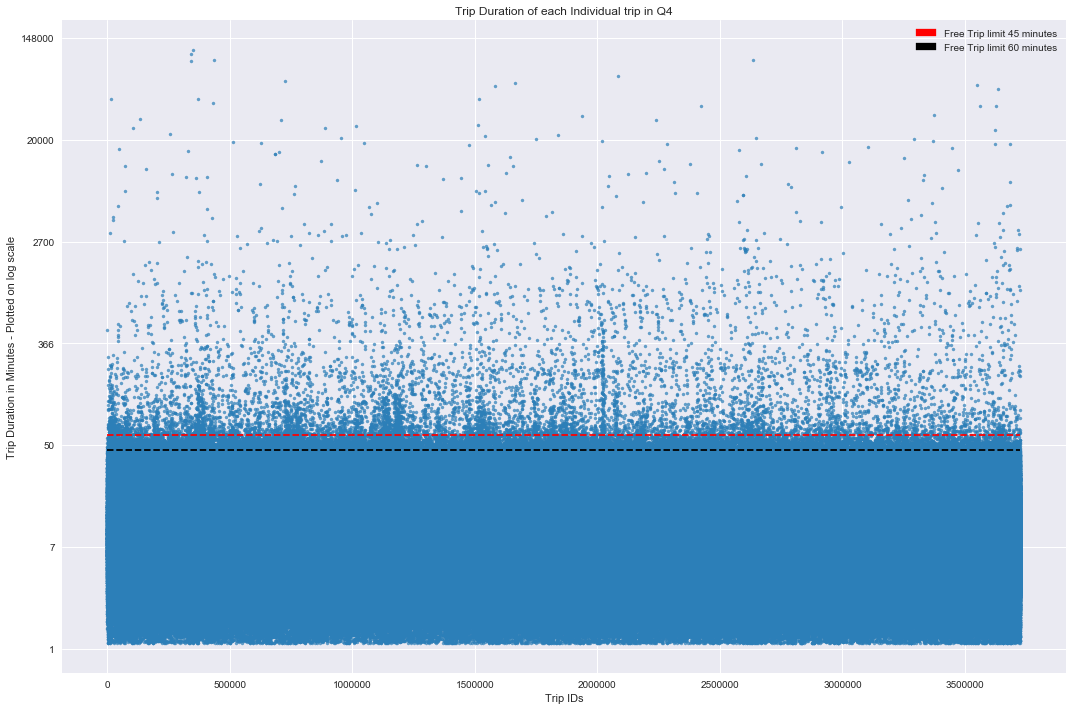

In [69]:
# Plot Trip Duration of each trip and show the threhold of free trip limit of 45 minutes for Subscribers
import matplotlib.patches as mpatches

# we need to create the log scale for trip duration to fit in uniform scale.
df_sub["logtripduration"] = np.log(df_sub["tripduration"])

df_sub.plot.scatter(x='trip_id', y='logtripduration', figsize=(18, 12), color='#2c7fb8', alpha=.7, linewidth=.2, label='Bike trips', s=10);

# draw two line to show the limit of free trip duration 45 minutes - log(45*60) and 60 minutes.
# log value of 2700 (45 minutes - free trip threshold) is 7.901 and log value of 3000 is 8.189

plt.plot([0, len(df_sub['trip_id'])], [7.90, 7.90], 'k--', color="Black")
plt.plot([0, len(df_sub['trip_id'])], [8.19, 8.19], 'k--', color="Red")
_ = plt.xlabel('Trip IDs')
_ = plt.ylabel('Trip Duration in Minutes - Plotted on log scale')
_ = plt.title('Trip Duration of each Individual trip in Q4')

tick_val = [4,6,8,10,12,14,16]
tick_lab = ['1','7','50','366','2700','20000','148000']
_ = plt.yticks(tick_val, tick_lab)

red_patch = mpatches.Patch(color='red', label='Free Trip limit 45 minutes')
blk_patch = mpatches.Patch(color='Black', label='Free Trip limit 60 minutes')

plt.legend(handles=[red_patch,blk_patch])

plt.show()


Average No of trips originating per Station in Q4 by Subscribers 4827.0


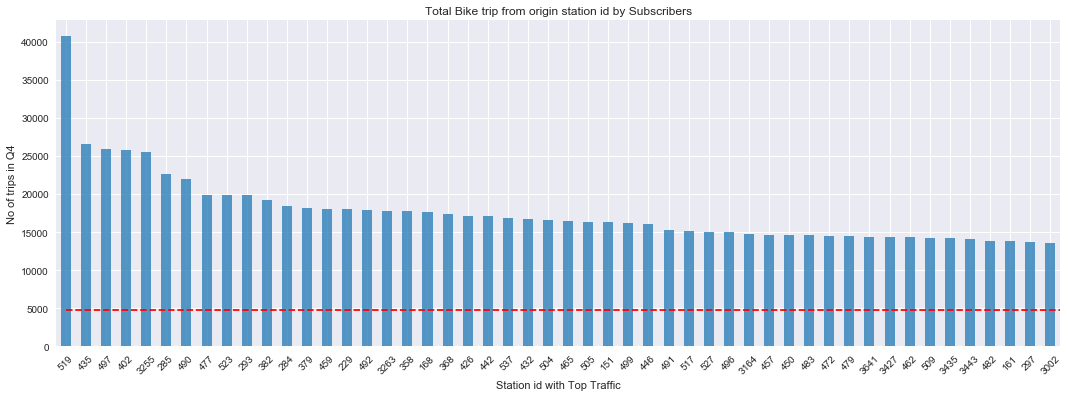

Average No of Paid trips originating per Station in Q4 by subscribers 34.0


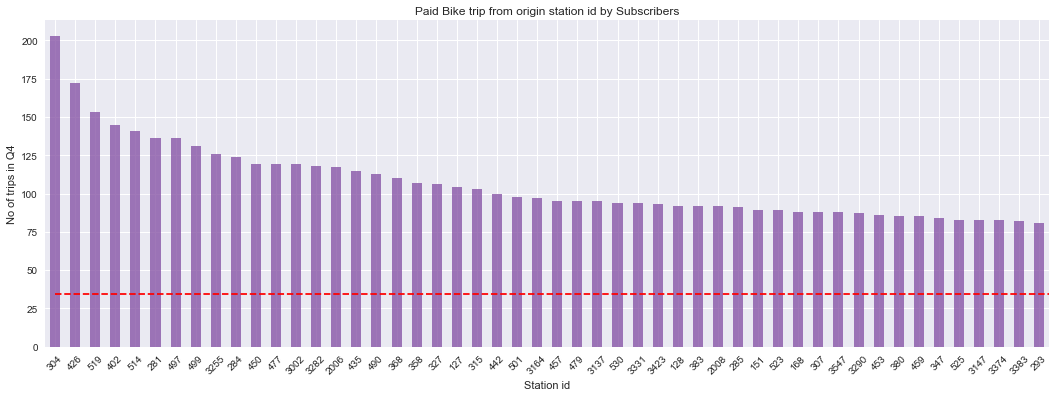

Average No of Paid trips originating per Station in Q4 by Customers 15.0


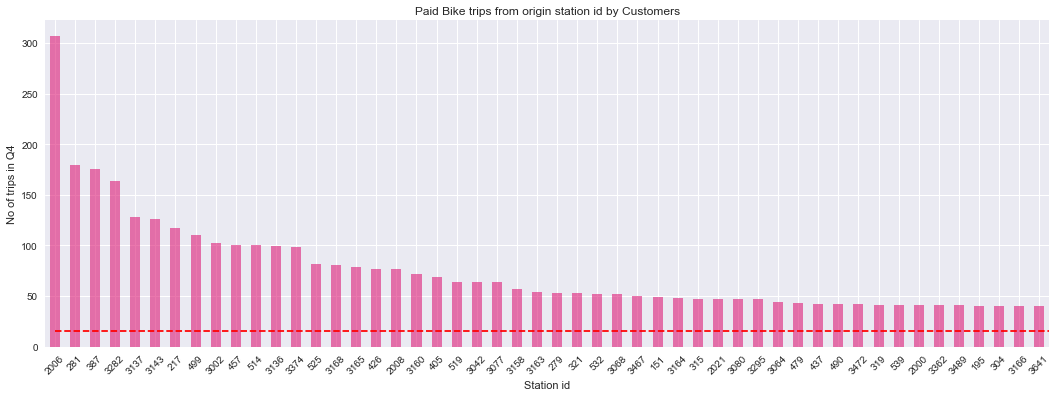

In [84]:
# Trip Origination Distribution by Station id: where are all trip starting from 

newdf1 = df_sub[['start_id']].groupby(df_sub['start_id']).count()
newdf1 = newdf1.rename(index=str, columns={"start_id": 'counts'})

av_trips_from_a_station = np.around(len(df_sub['trip_id'])/(len(newdf1['counts'])))
print("Average No of trips originating per Station in Q4 by Subscribers", av_trips_from_a_station)

#lets get top 30 Stattions based on no of trips

newdf = newdf1.nlargest(50, 'counts')

newdf.plot(kind='bar', figsize=(18, 6), label = '', legend=False, color='#2c7fb8', linewidth=.01, alpha=0.8)
plt.plot([0, len(newdf['counts'])], [av_trips_from_a_station, av_trips_from_a_station], 'k--', color="Red",)

plt.xlabel('Station id with Top Traffic')
plt.ylabel('No of trips in Q4')
_ = plt.xticks(rotation=45)
plt.title('Total Bike trip from origin station id by Subscribers')
plt.show()

#---------------------------------------------------------------------------------------------------#
# Trip Origination Distribution by Station id: Where are the long(paid) trips happening by Subsriber
# Find the paid trips (> 45 minutes) and show in plot when and where they are starting from.

df_paidtrip = df_sub.query("tripduration > 2700")
newdf = df_paidtrip[['start_id']].groupby(df_paidtrip['start_id']).count()
newdf = newdf.rename(index=str, columns={"start_id": 'counts'})

newdf_p = newdf.nlargest(50, 'counts')

av_paidtrip_from_a_station_bysub = np.around(len(df_paidtrip['trip_id'])/(len(newdf['counts'])))
print("Average No of Paid trips originating per Station in Q4 by subscribers", av_paidtrip_from_a_station_bysub)

newdf_p.plot(kind='bar', figsize=(18, 6), label = '', legend=False, color='#8856a7', linewidth=.1, alpha=0.8)
plt.plot([0, len(newdf_p['counts'])], [av_paidtrip_from_a_station_bysub, av_paidtrip_from_a_station_bysub], 'k--', color="Red",)
_ = plt.xticks(rotation=45)

plt.xlabel('Station id')
plt.ylabel('No of trips in Q4')
plt.title('Paid Bike trip from origin station id by Subscribers')
plt.show()

#---------------------------------------------------------------------------------------------------#
# Trip Origination Distribution by Station id: Where are the long(paid) trips happening by Customers
# For 1-Day or 3-Day pass holders

df_custpaidtrip = df_cust.query("tripduration > 1800")

newdf = df_custpaidtrip[['start_id']].groupby(df_custpaidtrip['start_id']).count()
newdf = newdf.rename(index=str, columns={"start_id": 'counts'})

newdf_pc = newdf.nlargest(50, 'counts')

av_paidtrip_from_a_station_bycust = np.around(len(df_custpaidtrip['trip_id'])/(len(newdf['counts'])))
print("Average No of Paid trips originating per Station in Q4 by Customers", av_paidtrip_from_a_station_bycust)

newdf_pc.plot(kind='bar', figsize=(18, 6), label = '', legend=False, color='#dd1c77', linewidth=.1, alpha=0.6)
plt.plot([0, len(newdf_pc['counts'])], [av_paidtrip_from_a_station_bycust, av_paidtrip_from_a_station_bycust], 'k--', color="Red",)
_ = plt.xticks(rotation=45)

plt.xlabel('Station id')
plt.ylabel('No of trips in Q4')
plt.title('Paid Bike trips from origin station id by Customers')
plt.show()

/Users/jitendra_agarwal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Average no of long trips by Day/Hour for subsriber  306.0


/Users/jitendra_agarwal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Average no of long trips by Day/Hour for customer  128.0


Text(0.5,1,'Peak Hours for long/paid trip by Day pass customers')

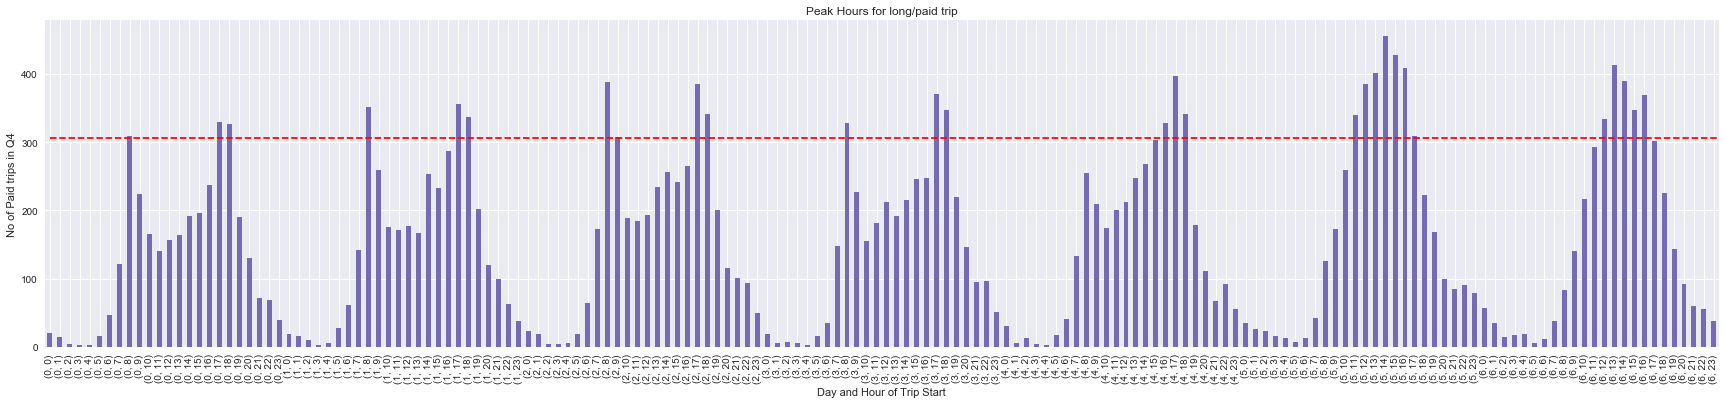

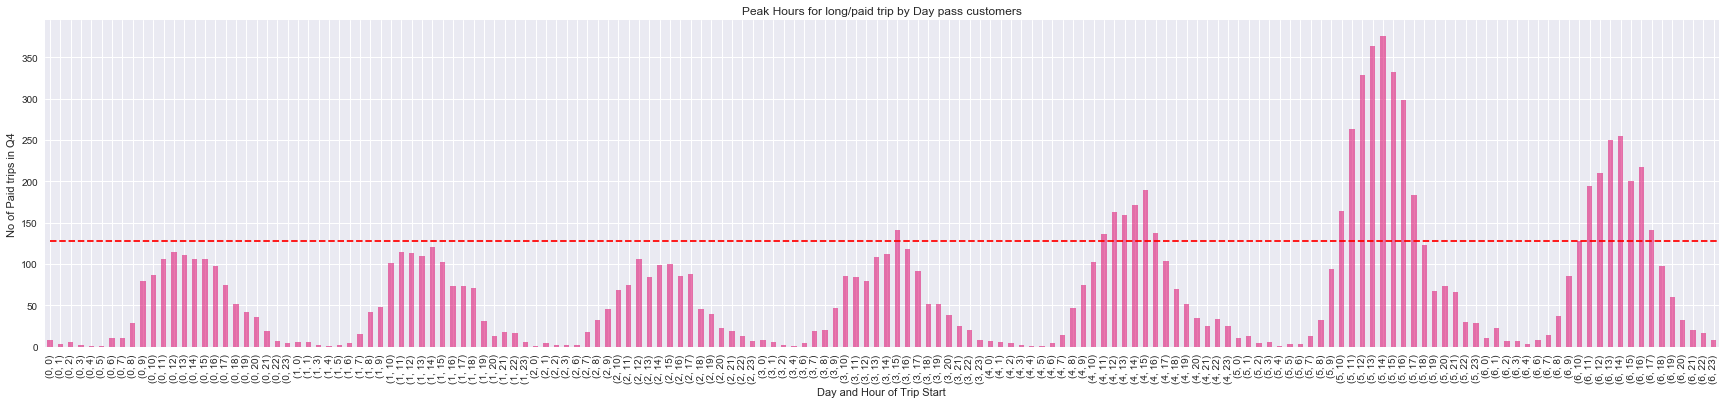

In [86]:
#Trip Distribution by Day/time of a week: When are the paid trips happening
df_paidtrip['paidunits'] = np.floor((df_paidtrip['tripduration']-2700)/900)

av_paid_trips_per_hour = np.around(len(df_paidtrip['paidunits'])/(24*7))
print("Average no of long trips by Day/Hour for subsriber ", 2*av_paid_trips_per_hour)

# Half od the day ( 8 PM to 8 AM) is non prime time to average multply by 2
df_agg_hour_day = pd.pivot_table(df_paidtrip, values='trip_id', index=([df_paidtrip['start_day'], df_paidtrip['starthour']]), aggfunc=np.count_nonzero)
df_agg_hour_day.plot(kind='bar', xticks=df_paidtrip.start_day, figsize=(30, 6), label = '', legend=False, color='#756bb1', linewidth=.05)
plt.plot([0, 168], [av_paid_trips_per_hour*2, av_paid_trips_per_hour*2], 'k--', color="Red",)

plt.xlabel('Day and Hour of Trip Start')
plt.ylabel('No of Paid trips in Q4')
plt.title('Peak Hours for long/paid trip')

#Trip Distribution by Day/time of a week: When are the paid trips happening by Day pass customers

df_custpaidtrip['paidunits'] = np.floor((df_custpaidtrip['tripduration']-1800)/900)

av_paid_trips_per_hour_cust = np.around(len(df_custpaidtrip['paidunits'])/(24*7))
print("Average no of long trips by Day/Hour for customer ", 2*av_paid_trips_per_hour_cust)

# Half of the day ( 8 PM to 8 AM) is non prime time to average multply by 2
df_agg_hour_day_cust = pd.pivot_table(df_custpaidtrip, values='trip_id', index=([df_custpaidtrip['start_day'], df_custpaidtrip['starthour']]), aggfunc=np.count_nonzero)
df_agg_hour_day_cust.plot(kind='bar', xticks=df_custpaidtrip.start_day, figsize=(30, 6), label = '', legend=False, color='#dd1c77', linewidth=.1, alpha=0.6)
plt.plot([0, 168], [av_paid_trips_per_hour_cust*2, av_paid_trips_per_hour_cust*2], 'k--', color="Red",)

plt.xlabel('Day and Hour of Trip Start')
plt.ylabel('No of Paid trips in Q4')
plt.title('Peak Hours for long/paid trip by Day pass customers')


gender          0        1        2
driver_age                         
17          210.0   2176.0    434.0
18          196.0   5582.0    977.0
19            6.0  11103.0   2067.0
20          214.0  17595.0   4377.0
21           99.0  19654.0   7189.0
22          489.0  24334.0  10656.0
23          214.0  34977.0  13758.0
24          286.0  52627.0  21409.0
25          704.0  77788.0  33827.0
26          449.0  94277.0  38478.0


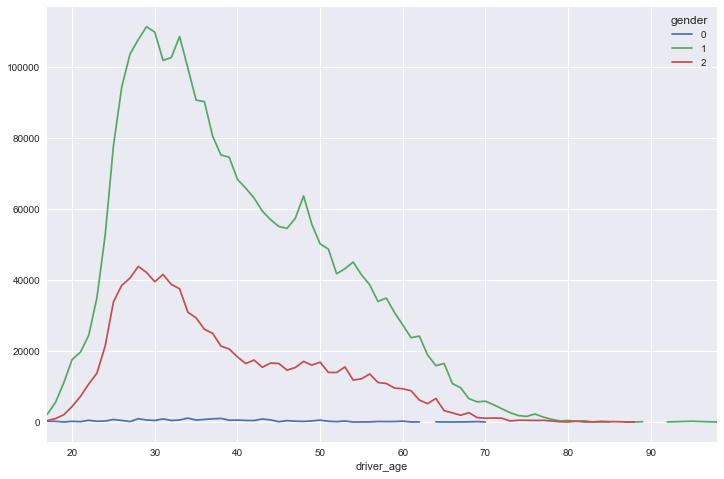

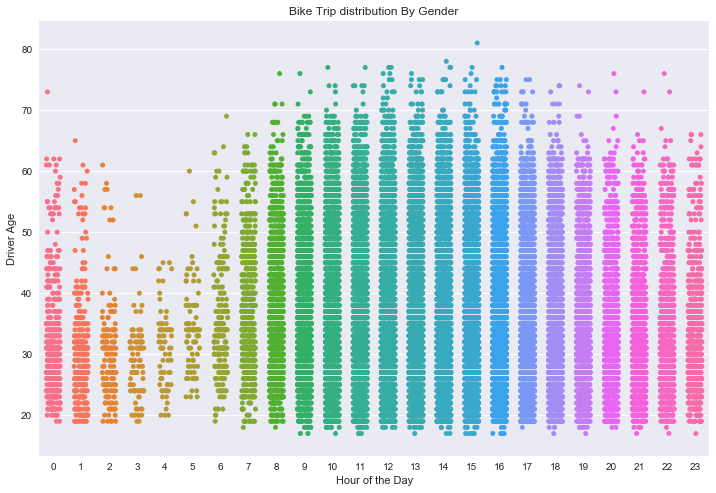

In [87]:
df_agg_trips = pd.pivot_table(df_sub, values='bikeid', index=df_sub['driver_age'], columns=['gender'], aggfunc=np.count_nonzero)
print(df_agg_trips.head(10))

df_agg_trips.plot(figsize=(12,8))

plt.figure(figsize=(12,8))
sns.stripplot(x="starthour", y="driver_age", data=df_cust, jitter=.25, palette="husl");
_ = plt.xlabel('Hour of the Day')
_ = plt.ylabel('Driver Age')
_ = plt.title('Bike Trip distribution By Gender')
plt.show()

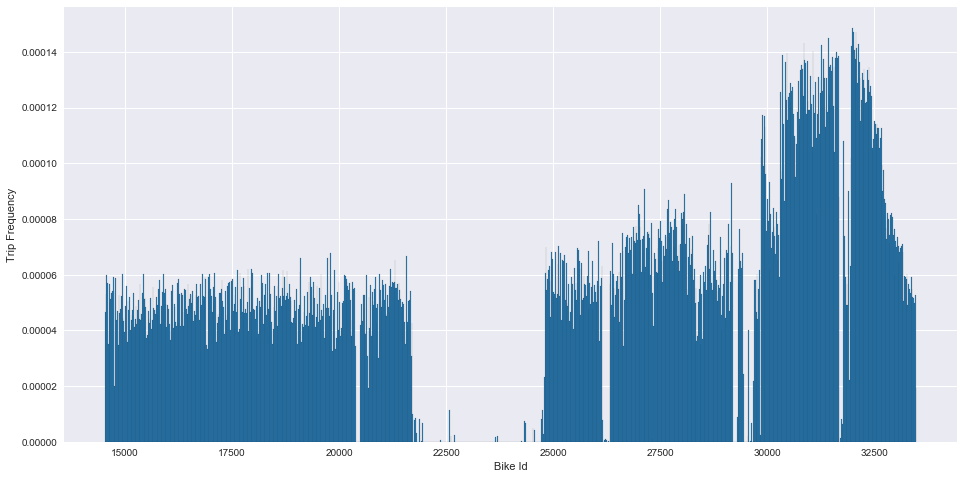

In [104]:

plt.figure(figsize=(16,8))
df_sub['bikeid'].plot('hist', label = '', legend=False, normed=True, color='#2c7fb8', edgecolor='black', linewidth=.1, bins=1000)
_ = plt.xlabel('Bike Id')
_ = plt.ylabel('Trip Frequency by a Bike')
plt.show()

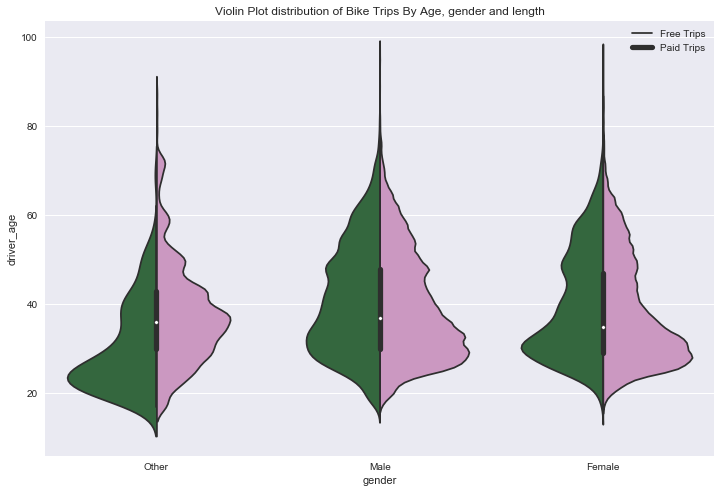

In [106]:
plt.figure(figsize=(12,8))
_ = plt.xlabel('Driver Gender')
_ = plt.ylabel('Driver Age')
_ = plt.title('Violin Plot distribution of Bike Trips By Age, gender and length')

plegend = ["Free Trips", "Paid Trips"]
ax = sns.violinplot(x="gender", y="driver_age", hue="free_trip", data=df_sub, split=True, palette="cubehelix", legend_out = False);
ax.set_xticklabels(['Other', 'Male', 'Female'])
ax.legend(plegend)

plt.show()

In [ ]:
# Lets Create a Heat map to show which station is busy againt the hour of the day.


In [ ]:
# calculate and plot the bike on road v/s bike in dock in time series


In [63]:
# Import figure from bokeh.plotting
from bokeh.plotting import figure

# Import output_file and show from bokeh.io
from bokeh.io import output_notebook, show

# Create the figure: p
p = figure(x_axis_label='trip_id', y_axis_label='logtripduration')

# Add a circle glyph to the figure p
p.circle(df_sub['trip_id'], df_sub['logtripduration'])

# Call the output_file() function and specify the name of the file
output_notebook()

# Display the plot
show(p)


Loading BokehJS ...

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
